In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
!unzip /content/drive/MyDrive/"Colab Notebooks"/521153S-3005-final-project.zip

Archive:  /content/drive/MyDrive/Colab_Notebooks/521153S-3005-final-project.zip
   creating: DeepDRiD/
 extracting: DeepDRiD/sample_submission.csv  
 extracting: DeepDRiD/test.csv       
   creating: DeepDRiD/test/
   creating: DeepDRiD/test/347/
 extracting: DeepDRiD/test/347/347_l1.jpg  
 extracting: DeepDRiD/test/347/347_l2.jpg  
 extracting: DeepDRiD/test/347/347_r1.jpg  
 extracting: DeepDRiD/test/347/347_r2.jpg  
   creating: DeepDRiD/test/353/
 extracting: DeepDRiD/test/353/353_l1.jpg  
 extracting: DeepDRiD/test/353/353_l2.jpg  
 extracting: DeepDRiD/test/353/353_r1.jpg  
 extracting: DeepDRiD/test/353/353_r2.jpg  
   creating: DeepDRiD/test/354/
 extracting: DeepDRiD/test/354/354_l1.jpg  
 extracting: DeepDRiD/test/354/354_l2.jpg  
 extracting: DeepDRiD/test/354/354_r1.jpg  
 extracting: DeepDRiD/test/354/354_r2.jpg  
   creating: DeepDRiD/test/366/
 extracting: DeepDRiD/test/366/366_l1.jpg  
 extracting: DeepDRiD/test/366/366_l2.jpg  
 extracting: DeepDRiD/test/366/366_r1.jpg

In [13]:
import copy
import os
import random
import sys

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from PIL import Image
from sklearn.metrics import cohen_kappa_score, precision_score, recall_score, accuracy_score
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.transforms.functional import to_pil_image
from tqdm import tqdm

# Hyper Parameters
batch_size = 24
num_classes = 5  # 5 DR levels
learning_rate = 0.0001
num_epochs = 10

In [14]:
class RetinopathyDataset(Dataset):
    def __init__(self, ann_file, image_dir, transform=None, mode='single', test=False):
        self.ann_file = ann_file
        self.image_dir = image_dir
        self.transform = transform

        self.test = test
        self.mode = mode

        if self.mode == 'single':
            self.data = self.load_data()
        else:
            self.data = self.load_data_dual()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        if self.mode == 'single':
            return self.get_item(index)
        else:
            return self.get_item_dual(index)

    # 1. single image
    def load_data(self):
        df = pd.read_csv(self.ann_file)

        data = []
        for _, row in df.iterrows():
            file_info = dict()
            file_info['img_path'] = os.path.join(self.image_dir, row['img_path'])
            if not self.test:
                file_info['dr_level'] = int(row['patient_DR_Level'])
            data.append(file_info)
        return data

    def get_item(self, index):
        data = self.data[index]
        img = Image.open(data['img_path']).convert('RGB')
        if self.transform:
            img = self.transform(img)

        if not self.test:
            label = torch.tensor(data['dr_level'], dtype=torch.int64)
            return img, label
        else:
            return img

    # 2. dual image
    def load_data_dual(self):
        df = pd.read_csv(self.ann_file)

        df['prefix'] = df['image_id'].str.split('_').str[0]  # The patient id of each image
        df['suffix'] = df['image_id'].str.split('_').str[1].str[0]  # The left or right eye
        grouped = df.groupby(['prefix', 'suffix'])

        data = []
        for (prefix, suffix), group in grouped:
            file_info = dict()
            file_info['img_path1'] = os.path.join(self.image_dir, group.iloc[0]['img_path'])
            file_info['img_path2'] = os.path.join(self.image_dir, group.iloc[1]['img_path'])
            if not self.test:
                file_info['dr_level'] = int(group.iloc[0]['patient_DR_Level'])
            data.append(file_info)
        return data

    def get_item_dual(self, index):
        data = self.data[index]
        img1 = Image.open(data['img_path1']).convert('RGB')
        img2 = Image.open(data['img_path2']).convert('RGB')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        if not self.test:
            label = torch.tensor(data['dr_level'], dtype=torch.int64)
            return [img1, img2], label
        else:
            return [img1, img2]

In [15]:
class CutOut(object):
    def __init__(self, mask_size, p=0.5):
        self.mask_size = mask_size
        self.p = p

    def __call__(self, img):
        if np.random.rand() > self.p:
            return img

        # Ensure the image is a tensor
        if not isinstance(img, torch.Tensor):
            raise TypeError('Input image must be a torch.Tensor')

        # Get height and width of the image
        h, w = img.shape[1], img.shape[2]
        mask_size_half = self.mask_size // 2
        offset = 1 if self.mask_size % 2 == 0 else 0

        cx = np.random.randint(mask_size_half, w + offset - mask_size_half)
        cy = np.random.randint(mask_size_half, h + offset - mask_size_half)

        xmin, xmax = cx - mask_size_half, cx + mask_size_half + offset
        ymin, ymax = cy - mask_size_half, cy + mask_size_half + offset
        xmin, xmax = max(0, xmin), min(w, xmax)
        ymin, ymax = max(0, ymin), min(h, ymax)

        img[:, ymin:ymax, xmin:xmax] = 0
        return img


In [16]:
class SLORandomPad:
    def __init__(self, size):
        self.size = size

    def __call__(self, img):
        pad_width = max(0, self.size[0] - img.width)
        pad_height = max(0, self.size[1] - img.height)
        pad_left = random.randint(0, pad_width)
        pad_top = random.randint(0, pad_height)
        pad_right = pad_width - pad_left
        pad_bottom = pad_height - pad_top
        return transforms.functional.pad(img, (pad_left, pad_top, pad_right, pad_bottom))

In [17]:
class FundRandomRotate:
    def __init__(self, prob, degree):
        self.prob = prob
        self.degree = degree

    def __call__(self, img):
        if random.random() < self.prob:
            angle = random.uniform(-self.degree, self.degree)
            return transforms.functional.rotate(img, angle)
        return img

In [18]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((210, 210)),
    SLORandomPad((224, 224)),
    FundRandomRotate(prob=0.5, degree=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=(0.1, 0.9)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [19]:
def train_model(model, train_loader, val_loader, device, criterion, optimizer, lr_scheduler, num_epochs,
                checkpoint_path='/content/drive/MyDrive/models/model1.pth'):
    best_model = model.state_dict()
    best_epoch = None
    best_val_kappa = -1.0  # Initialize the best kappa score

    for epoch in range(1, num_epochs + 1):
        print(f'\nEpoch {epoch}/{num_epochs}')
        running_loss = []
        all_preds = []
        all_labels = []

        model.train()

        with tqdm(total=len(train_loader), desc=f'Training', unit=' batch', file=sys.stdout) as pbar:
            for images, labels in train_loader:
                if not isinstance(images, list):
                    images = images.to(device)  # single image case
                else:
                    images = [x.to(device) for x in images]  # dual images case

                labels = labels.to(device)

                optimizer.zero_grad()

                outputs = model(images)
                loss = criterion(outputs, labels.long())

                loss.backward()
                optimizer.step()

                preds = torch.argmax(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                running_loss.append(loss.item())

                pbar.set_postfix({'lr': f'{optimizer.param_groups[0]["lr"]:.1e}', 'Loss': f'{loss.item():.4f}'})
                pbar.update(1)

        lr_scheduler.step()

        epoch_loss = sum(running_loss) / len(running_loss)

        train_metrics = compute_metrics(all_preds, all_labels, per_class=True)
        kappa, accuracy, precision, recall = train_metrics[:4]

        print(f'[Train] Kappa: {kappa:.4f} Accuracy: {accuracy:.4f} '
              f'Precision: {precision:.4f} Recall: {recall:.4f} Loss: {epoch_loss:.4f}')

        if len(train_metrics) > 4:
            precision_per_class, recall_per_class = train_metrics[4:]
            for i, (precision, recall) in enumerate(zip(precision_per_class, recall_per_class)):
                print(f'[Train] Class {i}: Precision: {precision:.4f}, Recall: {recall:.4f}')

        # Evaluation on the validation set at the end of each epoch
        val_metrics = evaluate_model(model, val_loader, device)
        val_kappa, val_accuracy, val_precision, val_recall = val_metrics[:4]
        print(f'[Val] Kappa: {val_kappa:.4f} Accuracy: {val_accuracy:.4f} '
              f'Precision: {val_precision:.4f} Recall: {val_recall:.4f}')

        if val_kappa > best_val_kappa:
            best_val_kappa = val_kappa
            best_epoch = epoch
            best_model = model.state_dict()
            torch.save(best_model, checkpoint_path)

    print(f'[Val] Best kappa: {best_val_kappa:.4f}, Epoch {best_epoch}')

    return model


In [20]:
def evaluate_model(model, test_loader, device, test_only=False, prediction_path='/content/drive/MyDrive/Predictions/test_predictions1.csv'):
    model.eval()

    all_preds = []
    all_labels = []
    all_image_ids = []

    with tqdm(total=len(test_loader), desc=f'Evaluating', unit=' batch', file=sys.stdout) as pbar:
        for i, data in enumerate(test_loader):

            if test_only:
                images = data
            else:
                images, labels = data

            if not isinstance(images, list):
                images = images.to(device)  # single image case
            else:
                images = [x.to(device) for x in images]  # dual images case

            with torch.no_grad():
                outputs = model(images)
                preds = torch.argmax(outputs, 1)

            if not isinstance(images, list):
                # single image case
                all_preds.extend(preds.cpu().numpy())
                image_ids = [
                    os.path.basename(test_loader.dataset.data[idx]['img_path']) for idx in
                    range(i * test_loader.batch_size, i * test_loader.batch_size + len(images))
                ]
                all_image_ids.extend(image_ids)
                if not test_only:
                    all_labels.extend(labels.numpy())
            else:
                # dual images case
                for k in range(2):
                    all_preds.extend(preds.cpu().numpy())
                    image_ids = [
                        os.path.basename(test_loader.dataset.data[idx][f'img_path{k + 1}']) for idx in
                        range(i * test_loader.batch_size, i * test_loader.batch_size + len(images[k]))
                    ]
                    all_image_ids.extend(image_ids)
                    if not test_only:
                        all_labels.extend(labels.numpy())

            pbar.update(1)

    # Save predictions to csv file for Kaggle online evaluation
    if test_only:
        df = pd.DataFrame({
            'ID': all_image_ids,
            'TARGET': all_preds
        })
        df.to_csv(prediction_path, index=False)
        print(f'[Test] Save predictions to {os.path.abspath(prediction_path)}')
    else:
        metrics = compute_metrics(all_preds, all_labels)
        return metrics


In [21]:
def compute_metrics(preds, labels, per_class=False):
    kappa = cohen_kappa_score(labels, preds, weights='quadratic')
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted', zero_division=0)
    recall = recall_score(labels, preds, average='weighted', zero_division=0)

    # Calculate and print precision and recall for each class
    if per_class:
        precision_per_class = precision_score(labels, preds, average=None, zero_division=0)
        recall_per_class = recall_score(labels, preds, average=None, zero_division=0)
        return kappa, accuracy, precision, recall, precision_per_class, recall_per_class

    return kappa, accuracy, precision, recall

In [22]:
class MyModel(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        self.backbone = models.resnet18(pretrained=True)

        # self.backbone = models.resnet34(pretrained=True)
        # state_dict = torch.load('pretrained/resnet34.pth', map_location='cpu')

        # self.backbone = models.vgg16(pretrained=True)
        # self.backbone.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # state_dict = torch.load('pretrained/vgg16.pth', map_location='cpu')

        # self.backbone = models.efficientnet_b0(pretrained=True)
        # state_dict = torch.load('pretrained/efficientnet_b0.pth', map_location='cpu')

        # self.backbone = models.densenet121(pretrained=True)
        # state_dict = torch.load('pretrained/densenet121.pth', map_location='cpu')
        self.backbone.fc = nn.Identity()  # Remove the original classification layer

        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return x

In [ ]:
if __name__ == '__main__':
    # Choose between 'single image' and 'dual images' pipeline
    # This will affect the model definition, dataset pipeline, training and evaluation

    mode = 'single'  # forward single image to the model each time
    # mode = 'dual'  # forward two images of the same eye to the model and fuse the features

    assert mode in ('single', 'dual')

    # Define the model
    if mode == 'single':
        model = MyModel()
    else:
        model = MyDualModel()

    print(model, '\n')
    print('Pipeline Mode:', mode)

    # Create datasets
    train_dataset = RetinopathyDataset('/content/DeepDRiD/train.csv', '/content/DeepDRiD/train', transform_train, mode)
    val_dataset = RetinopathyDataset('/content/DeepDRiD/val.csv', '/content/DeepDRiD/val/', transform_test, mode)
    test_dataset = RetinopathyDataset('/content/DeepDRiD/test.csv', '/content/DeepDRiD/test', transform_test, mode, test=True)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define the weighted CrossEntropyLoss
    criterion = nn.CrossEntropyLoss()

    # Use GPU device is possible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Device:', device)

    # Move class weights to the device
    model = model.to(device)

    # Optimizer and Learning rate scheduler
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Train and evaluate the model with the training and validation set
    model = train_model(
        model, train_loader, val_loader, device, criterion, optimizer,
        lr_scheduler=lr_scheduler, num_epochs=num_epochs,
        checkpoint_path='/content/drive/MyDrive/models/model1.pth'
    )

    # Load the pretrained checkpoint
    state_dict = torch.load('/content/drive/MyDrive/models/model1.pth', map_location='cpu')
    model.load_state_dict(state_dict, strict=True)

    # Make predictions on testing set and save the prediction results
    evaluate_model(model, test_loader, device, test_only=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MyModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

<ipython-input-18-3579f0252b28>:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/content/drive/MyDrive/models/model1.pth', map_location='cpu')


Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.92 batch/s]
[Test] Save predictions to /content/drive/MyDrive/Predictions/test_predictions1.csv


In [ ]:
if __name__ == '__main__':
    # Choose between 'single image' and 'dual images' pipeline
    # This will affect the model definition, dataset pipeline, training and evaluation

    mode = 'single'  # forward single image to the model each time
    # mode = 'dual'  # forward two images of the same eye to the model and fuse the features

    assert mode in ('single', 'dual')

    # Define the model
    if mode == 'single':
        model = MyModel()
    else:
        model = MyDualModel()

    print(model, '\n')
    print('Pipeline Mode:', mode)

    # tuned Hyper Parameters
    batch_size = 16
    num_classes = 5  # 5 DR levels
    learning_rate = 0.0001
    num_epochs = 15

    # Create datasets
    train_dataset = RetinopathyDataset('/content/DeepDRiD/train.csv', '/content/DeepDRiD/train', transform_train, mode)
    val_dataset = RetinopathyDataset('/content/DeepDRiD/val.csv', '/content/DeepDRiD/val/', transform_test, mode)
    test_dataset = RetinopathyDataset('/content/DeepDRiD/test.csv', '/content/DeepDRiD/test', transform_test, mode, test=True)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define the weighted CrossEntropyLoss
    criterion = nn.CrossEntropyLoss()

    # Use GPU device is possible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Device:', device)

    # Move class weights to the device
    model = model.to(device)

    # Optimizer and Learning rate scheduler
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Train and evaluate the model with the training and validation set
    model = train_model(
        model, train_loader, val_loader, device, criterion, optimizer,
        lr_scheduler=lr_scheduler, num_epochs=num_epochs,
        checkpoint_path='/content/drive/MyDrive/models/model2.pth'
    )

    # Load the pretrained checkpoint
    state_dict = torch.load('/content/drive/MyDrive/models/model2.pth', map_location='cpu')
    model.load_state_dict(state_dict, strict=True)

    # Make predictions on testing set and save the prediction results
    evaluate_model(model, test_loader, device, test_only=True, prediction_path='/content/drive/MyDrive/Predictions/test_predictions2.csv')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MyModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

<ipython-input-21-3afbd131cb23>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/content/drive/MyDrive/models/model2.pth', map_location='cpu')



[Val] Kappa: 0.7839 Accuracy: 0.6375 Precision: 0.6119 Recall: 0.6375
[Val] Best kappa: 0.8022, Epoch 11
Evaluating: 100%|██████████| 25/25 [00:02<00:00,  8.50 batch/s]
[Test] Save predictions to /content/drive/MyDrive/Predictions/test_predictions2.csv


In [23]:
class MyModel_resnet18(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        self.backbone = models.resnet18(pretrained=True)
        state_dict = torch.load('pretrained_DR_resize/pretrained/resnet18.pth', map_location='cpu')
        info = self.backbone.load_state_dict(state_dict, strict=False)
        print('missing keys:', info[0])  # The missing fc or classifier layer is normal here
        print('unexpected keys:', info[1])

        # self.backbone = models.resnet34(pretrained=True)
        # state_dict = torch.load('pretrained/resnet34.pth', map_location='cpu')

        # self.backbone = models.vgg16(pretrained=True)
        # self.backbone.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # state_dict = torch.load('pretrained/vgg16.pth', map_location='cpu')

        # self.backbone = models.efficientnet_b0(pretrained=True)
        # state_dict = torch.load('pretrained/efficientnet_b0.pth', map_location='cpu')

        # self.backbone = models.densenet121(pretrained=True)
        # state_dict = torch.load('pretrained/densenet121.pth', map_location='cpu')
        self.backbone.fc = nn.Identity()  # Remove the original classification layer

        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return x

In [ ]:






if __name__ == '__main__':
    # Choose between 'single image' and 'dual images' pipeline
    # This will affect the model definition, dataset pipeline, training and evaluation

    mode = 'single'  # forward single image to the model each time
    # mode = 'dual'  # forward two images of the same eye to the model and fuse the features

    assert mode in ('single', 'dual')

    # Define the model
    if mode == 'single':
        model = MyModel()
    else:
        model = MyDualModel()

    print(model, '\n')
    print('Pipeline Mode:', mode)

    # tuned Hyper Parameters
    batch_size = 16
    num_classes = 5  # 5 DR levels
    learning_rate = 0.0001
    num_epochs = 20

    # Create datasets
    train_dataset = RetinopathyDataset('/content/DeepDRiD/train.csv', '/content/DeepDRiD/train', transform_train, mode)
    val_dataset = RetinopathyDataset('/content/DeepDRiD/val.csv', '/content/DeepDRiD/val/', transform_test, mode)
    test_dataset = RetinopathyDataset('/content/DeepDRiD/test.csv', '/content/DeepDRiD/test', transform_test, mode, test=True)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    SLORandomPad((224, 224)),
    FundRandomRotate(prob=0.5, degree=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=(0.1, 0.9)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Define the weighted CrossEntropyLoss
    criterion = nn.CrossEntropyLoss()

    # Use GPU device is possible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Device:', device)

    # Move class weights to the device
    model = model.to(device)

    # Optimizer and Learning rate scheduler
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

     # Train and evaluate the model with the training and validation set
    model = train_model(
        model, train_loader, val_loader, device, criterion, optimizer,
        lr_scheduler=lr_scheduler, num_epochs=num_epochs,
        checkpoint_path='/content/drive/MyDrive/models/model3.pth'
    )

    # Load the pretrained checkpoint
    state_dict = torch.load('/content/drive/MyDrive/models/model3.pth', map_location='cpu')
    model.load_state_dict(state_dict, strict=True)

    # Make predictions on testing set and save the prediction results
    evaluate_model(model, test_loader, device, test_only=True, prediction_path='/content/drive/MyDrive/Predictions/test_predictions3.csv')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-22-2dee11ae0e4e>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detail

missing keys: ['fc.weight', 'fc.bias']
unexpected keys: []
MyModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): Bat

<ipython-input-23-8a16ceb53830>:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/content/drive/MyDrive/models/model3.pth', map_location='cpu')



[Val] Kappa: 0.8274 Accuracy: 0.6800 Precision: 0.6598 Recall: 0.6800
[Val] Best kappa: 0.8563, Epoch 14
Evaluating: 100%|██████████| 25/25 [00:02<00:00,  9.28 batch/s]
[Test] Save predictions to /content/drive/MyDrive/Predictions/test_predictions3.csv


In [24]:
class MyModel_resnet34(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        # self.backbone = models.resnet18(pretrained=True)
        # state_dict = torch.load('pretrained_DR_resize/pretrained/resnet18.pth', map_location='cpu')


        self.backbone = models.resnet34(pretrained=True)
        state_dict = torch.load('pretrained_DR_resize/pretrained/resnet34.pth', map_location='cpu')

        # self.backbone = models.vgg16(pretrained=True)
        # self.backbone.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # state_dict = torch.load('pretrained/vgg16.pth', map_location='cpu')

        # self.backbone = models.efficientnet_b0(pretrained=True)
        # state_dict = torch.load('pretrained/efficientnet_b0.pth', map_location='cpu')

        # self.backbone = models.densenet121(pretrained=True)
        # state_dict = torch.load('pretrained/densenet121.pth', map_location='cpu')

        info = self.backbone.load_state_dict(state_dict, strict=False)
        print('missing keys:', info[0])  # The missing fc or classifier layer is normal here
        print('unexpected keys:', info[1])

        self.backbone.fc = nn.Identity()  # Remove the original classification layer

        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return x

In [ ]:






if __name__ == '__main__':
    # Choose between 'single image' and 'dual images' pipeline
    # This will affect the model definition, dataset pipeline, training and evaluation

    mode = 'single'  # forward single image to the model each time
    # mode = 'dual'  # forward two images of the same eye to the model and fuse the features

    assert mode in ('single', 'dual')

    # Define the model
    if mode == 'single':
        model = MyModel()
    else:
        model = MyDualModel()

    print(model, '\n')
    print('Pipeline Mode:', mode)

    # tuned Hyper Parameters
    batch_size = 16
    num_classes = 5  # 5 DR levels
    learning_rate = 0.0001
    num_epochs = 20

    # Create datasets
    train_dataset = RetinopathyDataset('/content/DeepDRiD/train.csv', '/content/DeepDRiD/train', transform_train, mode)
    val_dataset = RetinopathyDataset('/content/DeepDRiD/val.csv', '/content/DeepDRiD/val/', transform_test, mode)
    test_dataset = RetinopathyDataset('/content/DeepDRiD/test.csv', '/content/DeepDRiD/test', transform_test, mode, test=True)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    SLORandomPad((224, 224)),
    FundRandomRotate(prob=0.5, degree=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=(0.1, 0.9)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Define the weighted CrossEntropyLoss
    criterion = nn.CrossEntropyLoss()

    # Use GPU device is possible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Device:', device)

    # Move class weights to the device
    model = model.to(device)

    # Optimizer and Learning rate scheduler
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

     # Train and evaluate the model with the training and validation set
    model = train_model(
        model, train_loader, val_loader, device, criterion, optimizer,
        lr_scheduler=lr_scheduler, num_epochs=num_epochs,
        checkpoint_path='/content/drive/MyDrive/models/model4.pth'
    )

    # Load the pretrained checkpoint
    state_dict = torch.load('/content/drive/MyDrive/models/model4.pth', map_location='cpu')
    model.load_state_dict(state_dict, strict=True)

    # Make predictions on testing set and save the prediction results
    evaluate_model(model, test_loader, device, test_only=True, prediction_path='/content/drive/MyDrive/Predictions/test_predictions4.csv')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 113MB/s]
<ipython-input-24-b6c7b0790233>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is poss

missing keys: ['fc.weight', 'fc.bias']
unexpected keys: []
MyModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): Bat

<ipython-input-25-6ebebff37fa4>:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/content/drive/MyDrive/models/model4.pth', map_location='cpu')


Evaluating: 100%|██████████| 25/25 [00:03<00:00,  6.88 batch/s]
[Test] Save predictions to /content/drive/MyDrive/Predictions/test_predictions4.csv


In [25]:
import torch.nn.functional as F
def train_model_EfficientNet(model, train_loader, val_loader, device, criterion, optimizer, lr_scheduler, num_epochs,
                checkpoint_path):
    """
    Train the model using EfficientNet-B0 as the backbone.

    Args:
        model (nn.Module): The PyTorch model to train.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        device (torch.device): Device to run the training on (CPU or GPU).
        criterion: Loss function.
        optimizer: Optimizer for model training.
        lr_scheduler: Learning rate scheduler.
        num_epochs (int): Number of epochs to train for.
        checkpoint_path (str): Path to save the best model checkpoint.

    Returns:
        nn.Module: The trained model.
    """
    best_model = model.state_dict()
    best_epoch = None
    best_val_kappa = -1.0  # Initialize the best kappa score

    for epoch in range(1, num_epochs + 1):
        print(f'\nEpoch {epoch}/{num_epochs}')
        running_loss = []
        all_preds = []
        all_labels = []

        model.train()

        with tqdm(total=len(train_loader), desc=f'Training', unit=' batch', file=sys.stdout) as pbar:
            for images, labels in train_loader:
                # Resize images to match EfficientNet-B0 input size
                images = F.interpolate(images, size=(224, 224), mode='bilinear', align_corners=False)

                images = images.to(device)  # Send images to device
                labels = labels.to(device)  # Send labels to device

                optimizer.zero_grad()

                outputs = model(images)  # Forward pass
                loss = criterion(outputs, labels.long())

                loss.backward()  # Backpropagation
                optimizer.step()  # Optimizer step

                preds = torch.argmax(outputs, 1)  # Get predicted labels
                all_preds.extend(preds.cpu().numpy())  # Collect predictions
                all_labels.extend(labels.cpu().numpy())  # Collect true labels

                running_loss.append(loss.item())  # Track loss

                pbar.set_postfix({'lr': f'{optimizer.param_groups[0]["lr"]:.1e}', 'Loss': f'{loss.item():.4f}'})
                pbar.update(1)

        lr_scheduler.step()  # Update learning rate

        epoch_loss = sum(running_loss) / len(running_loss)

        train_metrics = compute_metrics(all_preds, all_labels, per_class=True)  # Compute metrics
        kappa, accuracy, precision, recall = train_metrics[:4]

        print(f'[Train] Kappa: {kappa:.4f} Accuracy: {accuracy:.4f} '
              f'Precision: {precision:.4f} Recall: {recall:.4f} Loss: {epoch_loss:.4f}')

        if len(train_metrics) > 4:
            precision_per_class, recall_per_class = train_metrics[4:]
            for i, (precision, recall) in enumerate(zip(precision_per_class, recall_per_class)):
                print(f'[Train] Class {i}: Precision: {precision:.4f}, Recall: {recall:.4f}')

        # Evaluation on the validation set
        val_metrics = evaluate_model(model, val_loader, device)
        val_kappa, val_accuracy, val_precision, val_recall = val_metrics[:4]

        print(f'[Val] Kappa: {val_kappa:.4f} Accuracy: {val_accuracy:.4f} '
              f'Precision: {val_precision:.4f} Recall: {val_recall:.4f}')

        # Save the best model based on validation kappa
        if val_kappa > best_val_kappa:
            best_val_kappa = val_kappa
            best_epoch = epoch
            best_model = model.state_dict()
            torch.save(best_model, checkpoint_path)

    print(f'[Val] Best kappa: {best_val_kappa:.4f}, Epoch {best_epoch}')

    # Load the best model before returning
    model.load_state_dict(best_model)
    return model


In [26]:
class MyModel_efficientnet(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        # self.backbone = models.resnet18(pretrained=True)
        # state_dict = torch.load('pretrained_DR_resize/pretrained/resnet18.pth', map_location='cpu')


        # self.backbone = models.resnet34(pretrained=True)
        # state_dict = torch.load('pretrained_DR_resize/pretrained/resnet34.pth', map_location='cpu')

        # self.backbone = models.vgg16(pretrained=True)
        # self.backbone.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # state_dict = torch.load('pretrained/vgg16.pth', map_location='cpu')

        self.backbone = models.efficientnet_b0(pretrained=True)
        state_dict = torch.load('pretrained_DR_resize/pretrained/efficientnet_b0.pth', map_location='cpu')

        # self.backbone = models.densenet121(pretrained=True)
        # state_dict = torch.load('pretrained/densenet121.pth', map_location='cpu')

        info = self.backbone.load_state_dict(state_dict, strict=False)
        print('missing keys:', info[0])  # The missing fc or classifier layer is normal here
        print('unexpected keys:', info[1])

        self.backbone.classifier = nn.Sequential()  # Ensure no residual classifier

        self.backbone.fc = nn.Identity()  # Remove the original classification layer

        self.fc = nn.Sequential(
            nn.Linear(1280, 256),  # EfficientNet-B0 outputs 1280 features
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return x

In [ ]:
if __name__ == '__main__':
    # Choose between 'single image' and 'dual images' pipeline
    # This will affect the model definition, dataset pipeline, training and evaluation

    mode = 'single'  # forward single image to the model each time
    # mode = 'dual'  # forward two images of the same eye to the model and fuse the features

    assert mode in ('single', 'dual')

    # Define the model
    if mode == 'single':
        model = MyModel()
    else:
        model = MyDualModel()

    print(model, '\n')
    print('Pipeline Mode:', mode)

    # tuned Hyper Parameters
    batch_size = 16
    num_classes = 5  # 5 DR levels
    learning_rate = 0.0001
    num_epochs = 20

    # Create datasets
    train_dataset = RetinopathyDataset('/content/DeepDRiD/train.csv', '/content/DeepDRiD/train', transform_train, mode)
    val_dataset = RetinopathyDataset('/content/DeepDRiD/val.csv', '/content/DeepDRiD/val/', transform_test, mode)
    test_dataset = RetinopathyDataset('/content/DeepDRiD/test.csv', '/content/DeepDRiD/test', transform_test, mode, test=True)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    SLORandomPad((224, 224)),
    FundRandomRotate(prob=0.5, degree=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=(0.1, 0.9)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Define the weighted CrossEntropyLoss
    criterion = nn.CrossEntropyLoss()

    # Use GPU device is possible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Device:', device)

    # Move class weights to the device
    model = model.to(device)

    # Optimizer and Learning rate scheduler
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

     # Train and evaluate the model with the training and validation set
    model = train_model_EfficientNet(
        model, train_loader, val_loader, device, criterion, optimizer,
        lr_scheduler=lr_scheduler, num_epochs=num_epochs,
        checkpoint_path='/content/drive/MyDrive/models/model5.pth'
    )

    # Load the pretrained checkpoint
    state_dict = torch.load('/content/drive/MyDrive/models/model5.pth', map_location='cpu')
    model.load_state_dict(state_dict, strict=True)

    # Make predictions on testing set and save the prediction results
    evaluate_model(model, test_loader, device, test_only=True, prediction_path='/content/drive/MyDrive/Predictions/test_predictions5.csv')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-45-25bf9b928b30>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models 

missing keys: ['classifier.1.weight', 'classifier.1.bias']
unexpected keys: []
MyModel(
  (backbone): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(

<ipython-input-46-8578a8f61049>:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/content/drive/MyDrive/models/model5.pth', map_location='cpu')


Evaluating: 100%|██████████| 25/25 [00:03<00:00,  7.38 batch/s]
[Test] Save predictions to /content/drive/MyDrive/Predictions/test_predictions5.csv


In [27]:
# prompt: Implement only one attention mechanisms (e.g., self-attention, channel attention, or spatial attention) in this model archtecture.

import torch
import torch.nn as nn
import torch.nn.functional as F

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1   = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

class MyModel(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()
        self.backbone = models.efficientnet_b0(pretrained=True)
        state_dict = torch.load('pretrained_DR_resize/pretrained/efficientnet_b0.pth', map_location='cpu')
        info = self.backbone.load_state_dict(state_dict, strict=False)
        print('missing keys:', info[0])
        print('unexpected keys:', info[1])
        self.backbone.classifier = nn.Sequential()
        self.backbone.fc = nn.Identity()

        self.ca = ChannelAttention(1280) #Apply channel attention to the output of EfficientNet

        self.fc = nn.Sequential(
            nn.Linear(1280, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # x = self.backbone(x)
        # x = self.ca(x) * x # Apply channel attention
        # x = x.view(x.size(0),-1) # Flatten for the fully connected layers.
        # x = self.fc(x)
        x = self.backbone(x)  # EfficientNet feature extractor output
        x = x.unsqueeze(-1).unsqueeze(-1)  # Reshape to [batch_size, 1280, 1, 1] for ChannelAttention
        x = self.ca(x) * x  # Apply channel attention
        x = x.view(x.size(0), -1)  # Flatten for the fully connected layers
        x = self.fc(x)
        return x

In [ ]:
if __name__ == '__main__':
    # Choose between 'single image' and 'dual images' pipeline
    # This will affect the model definition, dataset pipeline, training and evaluation

    mode = 'single'  # forward single image to the model each time
    # mode = 'dual'  # forward two images of the same eye to the model and fuse the features

    assert mode in ('single', 'dual')

    # Define the model
    if mode == 'single':
        model = MyModel()
    else:
        model = MyDualModel()

    print(model, '\n')
    print('Pipeline Mode:', mode)

    # tuned Hyper Parameters
    batch_size = 16
    num_classes = 5  # 5 DR levels
    learning_rate = 0.0001
    num_epochs = 20

    # Create datasets
    train_dataset = RetinopathyDataset('/content/DeepDRiD/train.csv', '/content/DeepDRiD/train', transform_train, mode)
    val_dataset = RetinopathyDataset('/content/DeepDRiD/val.csv', '/content/DeepDRiD/val/', transform_test, mode)
    test_dataset = RetinopathyDataset('/content/DeepDRiD/test.csv', '/content/DeepDRiD/test', transform_test, mode, test=True)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    SLORandomPad((224, 224)),
    FundRandomRotate(prob=0.5, degree=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=(0.1, 0.9)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Define the weighted CrossEntropyLoss
    criterion = nn.CrossEntropyLoss()

    # Use GPU device is possible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Device:', device)

    # Move class weights to the device
    model = model.to(device)

    # Optimizer and Learning rate scheduler
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

     # Train and evaluate the model with the training and validation set
    model = train_model_EfficientNet(
        model, train_loader, val_loader, device, criterion, optimizer,
        lr_scheduler=lr_scheduler, num_epochs=num_epochs,
        checkpoint_path='/content/drive/MyDrive/models/model6.pth'
    )

    # Load the pretrained checkpoint
    state_dict = torch.load('/content/drive/MyDrive/models/model6.pth', map_location='cpu')
    model.load_state_dict(state_dict, strict=True)

    # Make predictions on testing set and save the prediction results
    evaluate_model(model, test_loader, device, test_only=True, prediction_path='/content/drive/MyDrive/Predictions/test_predictions6.csv')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-49-0847e2570fe0>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models 

missing keys: ['classifier.1.weight', 'classifier.1.bias']
unexpected keys: []
MyModel(
  (backbone): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(

<ipython-input-50-b101744f87fd>:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/content/drive/MyDrive/models/model6.pth', map_location='cpu')


Evaluating: 100%|██████████| 25/25 [00:02<00:00,  9.77 batch/s]
[Test] Save predictions to /content/drive/MyDrive/Predictions/test_predictions6.csv


In [28]:
def train_model(model, train_loader, val_loader, device, criterion, optimizer, lr_scheduler, num_epochs,
                checkpoint_path):
    best_model = model.state_dict()
    best_epoch = None
    best_val_kappa = -1.0  # Initialize the best kappa score

    for epoch in range(1, num_epochs + 1):
        print(f'\nEpoch {epoch}/{num_epochs}')
        running_loss = []
        all_preds = []
        all_labels = []

        model.train()

        with tqdm(total=len(train_loader), desc=f'Training', unit=' batch', file=sys.stdout) as pbar:
            for images, labels in train_loader:
                if not isinstance(images, list):
                    images = images.to(device)  # single image case
                else:
                    images = [x.to(device) for x in images]  # dual images case

                labels = labels.to(device)

                optimizer.zero_grad()

                outputs = model(images)
                loss = criterion(outputs, labels.long())

                loss.backward()
                optimizer.step()

                preds = torch.argmax(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                running_loss.append(loss.item())

                pbar.set_postfix({'lr': f'{optimizer.param_groups[0]["lr"]:.1e}', 'Loss': f'{loss.item():.4f}'})
                pbar.update(1)

        lr_scheduler.step()

        epoch_loss = sum(running_loss) / len(running_loss)

        train_metrics = compute_metrics(all_preds, all_labels, per_class=True)
        kappa, accuracy, precision, recall = train_metrics[:4]

        print(f'[Train] Kappa: {kappa:.4f} Accuracy: {accuracy:.4f} '
              f'Precision: {precision:.4f} Recall: {recall:.4f} Loss: {epoch_loss:.4f}')

        if len(train_metrics) > 4:
            precision_per_class, recall_per_class = train_metrics[4:]
            for i, (precision, recall) in enumerate(zip(precision_per_class, recall_per_class)):
                print(f'[Train] Class {i}: Precision: {precision:.4f}, Recall: {recall:.4f}')

        # Evaluation on the validation set at the end of each epoch
        val_metrics = evaluate_model(model, val_loader, device)
        val_kappa, val_accuracy, val_precision, val_recall = val_metrics[:4]
        print(f'[Val] Kappa: {val_kappa:.4f} Accuracy: {val_accuracy:.4f} '
              f'Precision: {val_precision:.4f} Recall: {val_recall:.4f}')

        if val_kappa > best_val_kappa:
            best_val_kappa = val_kappa
            best_epoch = epoch
            best_model = model.state_dict()
            torch.save(best_model, checkpoint_path)

    print(f'[Val] Best kappa: {best_val_kappa:.4f}, Epoch {best_epoch}')

    return model


In [29]:
# prompt: replace and Implement  channel attention mechanism in the above pretrained  resnet18 model architecture

import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1   = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

class MyModel(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()
        self.backbone = models.resnet18(pretrained=True)
        state_dict = torch.load('pretrained_DR_resize/pretrained/resnet18.pth', map_location='cpu')
        info = self.backbone.load_state_dict(state_dict, strict=False)
        print('missing keys:', info[0])  # The missing fc or classifier layer is normal here
        print('unexpected keys:', info[1])

        self.backbone.fc = nn.Identity() # Remove original FC layer

        self.ca = ChannelAttention(512) #Apply channel attention to the output of ResNet18

        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = x.unsqueeze(-1).unsqueeze(-1)
        x = self.ca(x) * x  # Apply channel attention
        x = torch.mean(x, dim=(2, 3)) # Global Average Pooling
        x = self.fc(x)
        return x

In [ ]:






if __name__ == '__main__':
    # Choose between 'single image' and 'dual images' pipeline
    # This will affect the model definition, dataset pipeline, training and evaluation

    mode = 'single'  # forward single image to the model each time
    # mode = 'dual'  # forward two images of the same eye to the model and fuse the features

    assert mode in ('single', 'dual')

    # Define the model
    if mode == 'single':
        model = MyModel()
    else:
        model = MyDualModel()

    print(model, '\n')
    print('Pipeline Mode:', mode)

    # tuned Hyper Parameters
    batch_size = 20
    num_classes = 5  # 5 DR levels
    learning_rate = 0.0001
    num_epochs = 15

    # Create datasets
    train_dataset = RetinopathyDataset('/content/DeepDRiD/train.csv', '/content/DeepDRiD/train', transform_train, mode)
    val_dataset = RetinopathyDataset('/content/DeepDRiD/val.csv', '/content/DeepDRiD/val/', transform_test, mode)
    test_dataset = RetinopathyDataset('/content/DeepDRiD/test.csv', '/content/DeepDRiD/test', transform_test, mode, test=True)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    SLORandomPad((224, 224)),
    FundRandomRotate(prob=0.5, degree=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=(0.1, 0.9)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Define the weighted CrossEntropyLoss
    criterion = nn.CrossEntropyLoss()

    # Use GPU device is possible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Device:', device)

    # Move class weights to the device
    model = model.to(device)

    # Optimizer and Learning rate scheduler
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

     # Train and evaluate the model with the training and validation set
    model = train_model(
        model, train_loader, val_loader, device, criterion, optimizer,
        lr_scheduler=lr_scheduler, num_epochs=num_epochs,
        checkpoint_path='/content/drive/MyDrive/models/model7.pth'
    )

    # Load the pretrained checkpoint
    state_dict = torch.load('/content/drive/MyDrive/models/model7.pth', map_location='cpu')
    model.load_state_dict(state_dict, strict=True)

    # Make predictions on testing set and save the prediction results
    evaluate_model(model, test_loader, device, test_only=True, prediction_path='/content/drive/MyDrive/Predictions/test_predictions7.csv')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-64-a69c3e767b96>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detai

missing keys: ['fc.weight', 'fc.bias']
unexpected keys: []
MyModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): Bat

<ipython-input-66-a8ead97ef4a4>:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/content/drive/MyDrive/models/model7.pth', map_location='cpu')


Evaluating: 100%|██████████| 20/20 [00:03<00:00,  6.39 batch/s]
[Test] Save predictions to /content/drive/MyDrive/Predictions/test_predictions7.csv


Task D

In [ ]:
# prompt: I have done model training with transfer learning with resnet18, resnet34 and EfficientNet. Which are now saved as model3.pth, model4.pth, model5.pth. Now perform ensemble learning. Try out the following ensemble techniques (Stacking, Boosting, Weighted Average, Max Voting, Bagging) and analyze whether the performance increases or not.

import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import cohen_kappa_score

# Load the trained models
#with taskb's resnet18
model3 = MyModel_resnet18().to(device)  # Assuming MyModel is defined as in your code
model3.load_state_dict(torch.load('/content/drive/MyDrive/models/model3.pth', map_location=device))
model3.eval()

#with taskb's resnet34
model4 = MyModel_resnet34().to(device)
model4.load_state_dict(torch.load('/content/drive/MyDrive/models/model4.pth', map_location=device))
model4.eval()

#with taskb's EfficientNet
model5 = MyModel_efficientnet().to(device)
model5.load_state_dict(torch.load('/content/drive/MyDrive/models/model5.pth', map_location=device))
model5.eval()

def ensemble_predictions(models, images):
    """
    Generate ensemble predictions from a list of models.

    Args:
        models (list): List of trained PyTorch models.
        images (torch.Tensor): Batch of input images.

    Returns:
        np.ndarray: Array of ensemble predictions.
    """
    predictions = []
    with torch.no_grad():
        for model in models:
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            predictions.append(preds)
    return np.array(predictions)


def evaluate_ensemble(ensemble_preds, true_labels):
    """
    Evaluate the performance of ensemble predictions.

    Args:
        ensemble_preds (list): List of lists, where each inner list contains predictions from different models.
        true_labels (list): True labels for the validation set.

    """
    # Concatenate all predictions and true labels into single arrays
    all_ensemble_preds = np.concatenate(ensemble_preds, axis=1) # Concatenate the prediction
    all_true_labels = np.concatenate(true_labels) # concatenate the true labels

    # 1. Weighted Average
    weighted_average_pred = np.round(np.mean(all_ensemble_preds, axis=0)).astype(int)
    kappa_weighted_avg = cohen_kappa_score(all_true_labels, weighted_average_pred, weights='quadratic')
    print(f"Weighted Average Kappa: {kappa_weighted_avg:.4f}")

    # 2. Max Voting
    max_voting_preds = np.apply_along_axis(lambda x: np.bincount(x, minlength=5).argmax(), axis=0, arr=all_ensemble_preds)
    kappa_max_voting = cohen_kappa_score(all_true_labels, max_voting_preds, weights='quadratic')
    print(f"Max Voting Kappa: {kappa_max_voting:.4f}")

    # 3. Stacking (Simplified as averaging predictions)
    stacked_preds = np.round(np.mean(all_ensemble_preds, axis=0)).astype(int)
    kappa_stacking = cohen_kappa_score(all_true_labels, stacked_preds, weights='quadratic')
    print(f"Stacking Kappa: {kappa_stacking:.4f}")

    # 4. Bagging (Simplified as averaging predictions)
    bagging_preds = np.round(np.mean(all_ensemble_preds, axis=0)).astype(int)
    kappa_bagging = cohen_kappa_score(all_true_labels, bagging_preds, weights='quadratic')
    print(f"Bagging Kappa: {kappa_bagging:.4f}")


# Now let's evaluate on the validation set:
if __name__ == "__main__":
    # ... (Rest of your code, such as model and dataloader definitions)

    mode = 'single'  # Ensure mode is defined

    # Create datasets
    train_dataset = RetinopathyDataset('/content/DeepDRiD/train.csv', '/content/DeepDRiD/train', transform_train, mode)
    val_dataset = RetinopathyDataset('/content/DeepDRiD/val.csv', '/content/DeepDRiD/val/', transform_test, mode)
    test_dataset = RetinopathyDataset('/content/DeepDRiD/test.csv', '/content/DeepDRiD/test', transform_test, mode, test=True)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    # Gather predictions and true labels from the validation set
    all_true_labels = []
    all_ensemble_preds = []

    # Corrected evaluation loop using the validation loader
    with torch.no_grad():
      for images, labels in val_loader:  # Use the validation loader
          images = images.to(device)
          labels = labels.cpu().numpy()

          # Perform ensemble prediction
          ensemble_preds = ensemble_predictions([model3, model4, model5], images)
          all_ensemble_preds.append(ensemble_preds)
          all_true_labels.append(labels)

    evaluate_ensemble(all_ensemble_preds, all_true_labels)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-72-77729cf7f76f>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detail

missing keys: ['fc.weight', 'fc.bias']
unexpected keys: []


<ipython-input-71-937141b994ba>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('pretrained_DR_resize/pretrained/resnet34.pth', map_location='cpu')

missing keys: ['fc.weight', 'fc.bias']
unexpected keys: []


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-73-16c542f796c9>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to b

missing keys: ['classifier.1.weight', 'classifier.1.bias']
unexpected keys: []
Weighted Average Kappa: 0.8638
Max Voting Kappa: 0.8467
Stacking Kappa: 0.8638
Bagging Kappa: 0.8638


Task D 2

In [30]:
# prompt: Now Try out different image preprocessing techniques such as, Ben Graham, Circle Cropping, CLAHE, adding gaussian blur, sharpening up the images etc.  Then see again if that has any effect on the model.

from PIL import Image, ImageEnhance, ImageFilter
import torchvision.transforms.functional as TF
import cv2
import numpy as np

# ... (Your existing code)

def ben_graham_preprocessing(image):
    # Convert to grayscale
    gray = image.convert('L')

    # Increase contrast (adjust factor as needed)
    enhancer = ImageEnhance.Contrast(gray)
    gray = enhancer.enhance(1.5)

    return gray

def circle_crop(image):
    # Convert the image to a NumPy array
    img_np = np.array(image)

    # Get the dimensions of the image
    height, width = img_np.shape[:2]

    # Create a black mask of the same size as the image
    mask = np.zeros((height, width), np.uint8)

    # Draw a white circle in the center of the mask
    center_x = width // 2
    center_y = height // 2
    radius = min(center_x, center_y)
    cv2.circle(mask, (center_x, center_y), radius, (255, 255, 255), -1)

    # Apply the mask to the image
    masked_img = cv2.bitwise_and(img_np, img_np, mask=mask)

    # Convert the masked image back to PIL format
    masked_image = Image.fromarray(masked_img)

    return masked_image

def clahe_preprocessing(image):
    # Convert PIL Image to OpenCV format
    # img_np = np.array(image)
    # lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)  # Convert to LAB color space

    # # Apply CLAHE
    # lab_planes = cv2.split(lab)
    # clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    # lab_planes[0] = clahe.apply(lab_planes[0])
    # lab = cv2.merge(lab_planes)

    # # Convert back to RGB
    # img_rgb = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    # # Convert back to PIL Image
    # img = Image.fromarray(img_rgb)
    # return img
    image_np = np.array(image)
    lab = cv2.cvtColor(image_np, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    image_np = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    return Image.fromarray(image_np)



def gaussian_blur_preprocessing(image):
  # Apply Gaussian Blur
  blurred_image = image.filter(ImageFilter.GaussianBlur(radius=1))
  return blurred_image


def sharpen_image(image):
    # Create a sharpening kernel
    kernel = np.array([[-1, -1, -1],
                       [-1,  9, -1],
                       [-1, -1, -1]])
    # Apply the kernel to the image
    img_np = np.array(image)
    sharpened_img = cv2.filter2D(img_np, -1, kernel)

    sharpened_image = Image.fromarray(sharpened_img)
    return sharpened_image


    # Example usage within your transform
transform_train = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop((224, 224)),
        SLORandomPad((224, 224)),
        FundRandomRotate(prob=0.5, degree=30),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ColorJitter(brightness=(0.1, 0.9)),
        #transforms.Lambda(lambda img: ben_graham_preprocessing(img)), # Ben Graham
        #transforms.Lambda(lambda img: circle_crop(img)), # Circle Cropping
        transforms.Lambda(lambda img: clahe_preprocessing(img)), # CLAHE
        #transforms.Lambda(lambda img: gaussian_blur_preprocessing(img)), #Gaussian Blur
        #transforms.Lambda(lambda img: sharpen_image(img)), #Sharpening
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        #transforms.Lambda(lambda img: ben_graham_preprocessing(img)), # Ben Graham
        #transforms.Lambda(lambda img: circle_crop(img)), # Circle Cropping
        transforms.Lambda(lambda img: clahe_preprocessing(img)), # CLAHE
        #transforms.Lambda(lambda img: gaussian_blur_preprocessing(img)), #Gaussian Blur
        #transforms.Lambda(lambda img: sharpen_image(img)), #Sharpening
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# ... (rest of your code)

In [31]:
class MyModel_resnet18(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        self.backbone = models.resnet18(pretrained=True)
        state_dict = torch.load('pretrained_DR_resize/pretrained/resnet18.pth', map_location='cpu')
        info = self.backbone.load_state_dict(state_dict, strict=False)
        print('missing keys:', info[0])  # The missing fc or classifier layer is normal here
        print('unexpected keys:', info[1])

        # self.backbone = models.resnet34(pretrained=True)
        # state_dict = torch.load('pretrained/resnet34.pth', map_location='cpu')

        # self.backbone = models.vgg16(pretrained=True)
        # self.backbone.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # state_dict = torch.load('pretrained/vgg16.pth', map_location='cpu')

        # self.backbone = models.efficientnet_b0(pretrained=True)
        # state_dict = torch.load('pretrained/efficientnet_b0.pth', map_location='cpu')

        # self.backbone = models.densenet121(pretrained=True)
        # state_dict = torch.load('pretrained/densenet121.pth', map_location='cpu')
        self.backbone.fc = nn.Identity()  # Remove the original classification layer

        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return x

In [ ]:






if __name__ == '__main__':
    # Choose between 'single image' and 'dual images' pipeline
    # This will affect the model definition, dataset pipeline, training and evaluation

    mode = 'single'  # forward single image to the model each time
    # mode = 'dual'  # forward two images of the same eye to the model and fuse the features

    assert mode in ('single', 'dual')

    # Define the model
    if mode == 'single':
        model = MyModel_resnet18()
    else:
        model = MyDualModel()

    print(model, '\n')
    print('Pipeline Mode:', mode)

    # tuned Hyper Parameters
    batch_size = 16
    num_classes = 5  # 5 DR levels
    learning_rate = 0.0001
    num_epochs = 20

    # Create datasets
    train_dataset = RetinopathyDataset('/content/DeepDRiD/train.csv', '/content/DeepDRiD/train', transform_train, mode)
    val_dataset = RetinopathyDataset('/content/DeepDRiD/val.csv', '/content/DeepDRiD/val/', transform_test, mode)
    test_dataset = RetinopathyDataset('/content/DeepDRiD/test.csv', '/content/DeepDRiD/test', transform_test, mode, test=True)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


    # Define the weighted CrossEntropyLoss
    criterion = nn.CrossEntropyLoss()

    # Use GPU device is possible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Device:', device)

    # Move class weights to the device
    model = model.to(device)

    # Optimizer and Learning rate scheduler
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

     # Train and evaluate the model with the training and validation set
    model = train_model(
        model, train_loader, val_loader, device, criterion, optimizer,
        lr_scheduler=lr_scheduler, num_epochs=num_epochs,
        checkpoint_path='/content/drive/MyDrive/models/model8.pth'
    )

    # Load the pretrained checkpoint
    state_dict = torch.load('/content/drive/MyDrive/models/model8.pth', map_location='cpu')
    model.load_state_dict(state_dict, strict=True)

    # Make predictions on testing set and save the prediction results
    evaluate_model(model, test_loader, device, test_only=True, prediction_path='/content/drive/MyDrive/Predictions/test_predictions8.csv')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-22-77729cf7f76f>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detail

missing keys: ['fc.weight', 'fc.bias']
unexpected keys: []
MyModel_resnet18(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (

<ipython-input-24-e95521dac2f2>:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/content/drive/MyDrive/models/model8.pth', map_location='cpu')



[Val] Kappa: 0.8426 Accuracy: 0.6850 Precision: 0.6650 Recall: 0.6850
[Val] Best kappa: 0.8542, Epoch 8
Evaluating: 100%|██████████| 25/25 [00:41<00:00,  1.68s/ batch]
[Test] Save predictions to /content/drive/MyDrive/Predictions/test_predictions8.csv


In [32]:
# prompt: Now Try out different image preprocessing techniques such as, Ben Graham, Circle Cropping, CLAHE, adding gaussian blur, sharpening up the images etc.  Then see again if that has any effect on the model.

from PIL import Image, ImageEnhance, ImageFilter
import torchvision.transforms.functional as TF
import cv2
import numpy as np

# ... (Your existing code)

def ben_graham_preprocessing(image):
    # Convert to grayscale
    gray = image.convert('L')

    # Increase contrast (adjust factor as needed)
    enhancer = ImageEnhance.Contrast(gray)
    gray = enhancer.enhance(1.5)

    return gray


def circle_crop(image):
    # Convert the image to a NumPy array
    img_np = np.array(image)

    # Get the dimensions of the image
    height, width = img_np.shape[:2]

    # Create a black mask of the same size as the image
    mask = np.zeros((height, width), np.uint8)

    # Draw a white circle in the center of the mask
    center_x = width // 2
    center_y = height // 2
    radius = min(center_x, center_y)
    cv2.circle(mask, (center_x, center_y), radius, (255, 255, 255), -1)

    # Apply the mask to the image
    masked_img = cv2.bitwise_and(img_np, img_np, mask=mask)

    # Convert the masked image back to PIL format
    masked_image = Image.fromarray(masked_img)

    return masked_image

def clahe_preprocessing(image):
    # Convert PIL Image to OpenCV format
    # img_np = np.array(image)
    # lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)  # Convert to LAB color space

    # # Apply CLAHE
    # lab_planes = cv2.split(lab)
    # clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    # lab_planes[0] = clahe.apply(lab_planes[0])
    # lab = cv2.merge(lab_planes)

    # # Convert back to RGB
    # img_rgb = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    # # Convert back to PIL Image
    # img = Image.fromarray(img_rgb)
    # return img
    image_np = np.array(image)
    lab = cv2.cvtColor(image_np, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    image_np = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    return Image.fromarray(image_np)



def gaussian_blur_preprocessing(image):
  # Apply Gaussian Blur
  blurred_image = image.filter(ImageFilter.GaussianBlur(radius=1))
  return blurred_image


def sharpen_image(image):
    # Create a sharpening kernel
    kernel = np.array([[-1, -1, -1],
                       [-1,  9, -1],
                       [-1, -1, -1]])
    # Apply the kernel to the image
    img_np = np.array(image)
    sharpened_img = cv2.filter2D(img_np, -1, kernel)

    sharpened_image = Image.fromarray(sharpened_img)
    return sharpened_image


    # Example usage within your transform
transform_train = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop((224, 224)),
        SLORandomPad((224, 224)),
        FundRandomRotate(prob=0.5, degree=30),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ColorJitter(brightness=(0.1, 0.9)),
        # transforms.Lambda(lambda img: ben_graham_preprocessing(img)), # Ben Graham
        #transforms.Lambda(lambda img: circle_crop(img)), # Circle Cropping
        # transforms.Lambda(lambda img: clahe_preprocessing(img)), # CLAHE
        transforms.Lambda(lambda img: gaussian_blur_preprocessing(img)), #Gaussian Blur
        #transforms.Lambda(lambda img: sharpen_image(img)), #Sharpening
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        #transforms.Lambda(lambda img: ben_graham_preprocessing(img)), # Ben Graham
        #transforms.Lambda(lambda img: circle_crop(img)), # Circle Cropping
        # transforms.Lambda(lambda img: clahe_preprocessing(img)), # CLAHE
        transforms.Lambda(lambda img: gaussian_blur_preprocessing(img)), #Gaussian Blur
        #transforms.Lambda(lambda img: sharpen_image(img)), #Sharpening
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# ... (rest of your code)

In [33]:
class MyModel_resnet18(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        self.backbone = models.resnet18(pretrained=True)
        state_dict = torch.load('pretrained_DR_resize/pretrained/resnet18.pth', map_location='cpu')
        info = self.backbone.load_state_dict(state_dict, strict=False)
        print('missing keys:', info[0])  # The missing fc or classifier layer is normal here
        print('unexpected keys:', info[1])

        # self.backbone = models.resnet34(pretrained=True)
        # state_dict = torch.load('pretrained/resnet34.pth', map_location='cpu')

        # self.backbone = models.vgg16(pretrained=True)
        # self.backbone.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # state_dict = torch.load('pretrained/vgg16.pth', map_location='cpu')

        # self.backbone = models.efficientnet_b0(pretrained=True)
        # state_dict = torch.load('pretrained/efficientnet_b0.pth', map_location='cpu')

        # self.backbone = models.densenet121(pretrained=True)
        # state_dict = torch.load('pretrained/densenet121.pth', map_location='cpu')
        self.backbone.fc = nn.Identity()  # Remove the original classification layer

        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return x

In [ ]:






if __name__ == '__main__':
    # Choose between 'single image' and 'dual images' pipeline
    # This will affect the model definition, dataset pipeline, training and evaluation

    mode = 'single'  # forward single image to the model each time
    # mode = 'dual'  # forward two images of the same eye to the model and fuse the features

    assert mode in ('single', 'dual')

    # Define the model
    if mode == 'single':
        model = MyModel_resnet18()
    else:
        model = MyDualModel()

    print(model, '\n')
    print('Pipeline Mode:', mode)

    # tuned Hyper Parameters
    batch_size = 16
    num_classes = 5  # 5 DR levels
    learning_rate = 0.0001
    num_epochs = 20

    # Create datasets
    train_dataset = RetinopathyDataset('/content/DeepDRiD/train.csv', '/content/DeepDRiD/train', transform_train, mode)
    val_dataset = RetinopathyDataset('/content/DeepDRiD/val.csv', '/content/DeepDRiD/val/', transform_test, mode)
    test_dataset = RetinopathyDataset('/content/DeepDRiD/test.csv', '/content/DeepDRiD/test', transform_test, mode, test=True)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


    # Define the weighted CrossEntropyLoss
    criterion = nn.CrossEntropyLoss()

    # Use GPU device is possible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Device:', device)

    # Move class weights to the device
    model = model.to(device)

    # Optimizer and Learning rate scheduler
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

     # Train and evaluate the model with the training and validation set
    model = train_model(
        model, train_loader, val_loader, device, criterion, optimizer,
        lr_scheduler=lr_scheduler, num_epochs=num_epochs,
        checkpoint_path='/content/drive/MyDrive/models/model9.pth'
    )

    # Load the pretrained checkpoint
    state_dict = torch.load('/content/drive/MyDrive/models/model9.pth', map_location='cpu')
    model.load_state_dict(state_dict, strict=True)

    # Make predictions on testing set and save the prediction results
    evaluate_model(model, test_loader, device, test_only=True, prediction_path='/content/drive/MyDrive/Predictions/test_predictions9.csv')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-34-77729cf7f76f>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detail

missing keys: ['fc.weight', 'fc.bias']
unexpected keys: []
MyModel_resnet18(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (

<ipython-input-35-88427ea331ec>:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/content/drive/MyDrive/models/model9.pth', map_location='cpu')



[Val] Kappa: 0.8430 Accuracy: 0.6875 Precision: 0.6584 Recall: 0.6875
[Val] Best kappa: 0.8511, Epoch 14
Evaluating: 100%|██████████| 25/25 [00:42<00:00,  1.70s/ batch]
[Test] Save predictions to /content/drive/MyDrive/Predictions/test_predictions9.csv


In [40]:
def train_model(model, train_loader, val_loader, device, criterion, optimizer, lr_scheduler, num_epochs,
                checkpoint_path):
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []  # Add these lists

    best_model = model.state_dict()
    best_val_kappa = -1.0

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss, all_preds, all_labels = [], [], []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            running_loss.append(loss.item())

        lr_scheduler.step()
        epoch_loss = sum(running_loss) / len(running_loss)
        train_losses.append(epoch_loss)

        accuracy = sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
        train_accuracies.append(accuracy)

        val_metrics = evaluate_model(model, val_loader, device)
        val_losses.append(sum(val_metrics) / len(val_metrics))
        val_accuracies.append(val_metrics[1])  # Assuming accuracy is at index 1

        print(f'Epoch {epoch}/{num_epochs} - Train Loss: {epoch_loss:.4f}, Train Accuracy: {accuracy:.4f}')

    return model, train_losses, val_losses, train_accuracies, val_accuracies


In [41]:
import matplotlib.pyplot as plt

def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 66.5MB/s]
<ipython-input-33-77729cf7f76f>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is poss

missing keys: ['fc.weight', 'fc.bias']
unexpected keys: []
MyModel_resnet18(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (

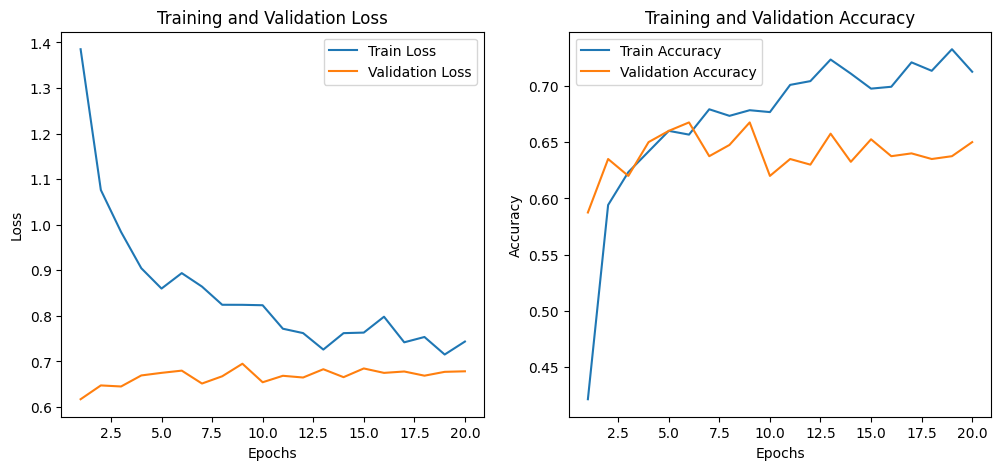

In [43]:
# Define the model
mode = 'single'
if mode == 'single':
    model = MyModel_resnet18(num_classes=5)  # Ensure MyModel_resnet18 is defined as per your previous code
else:
    model = MyDualModel()

print(model)

# Hyperparameters
batch_size = 16
learning_rate = 0.0001
num_epochs = 20

# Create datasets and dataloaders
train_dataset = RetinopathyDataset('/content/DeepDRiD/train.csv', '/content/DeepDRiD/train', transform_train, mode)
val_dataset = RetinopathyDataset('/content/DeepDRiD/val.csv', '/content/DeepDRiD/val', transform_test, mode)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define the loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Train the model
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, device, criterion, optimizer, lr_scheduler, num_epochs=num_epochs,
    checkpoint_path='/content/drive/MyDrive/models/model9.pth'
)

# Plot the training and validation curves
plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)


Evaluating: 100%|██████████| 25/25 [00:02<00:00, 10.50 batch/s]
Epoch 1/20 - Train Loss: 0.7633, Train Accuracy: 0.7142
Evaluating: 100%|██████████| 25/25 [00:02<00:00,  9.60 batch/s]
Epoch 2/20 - Train Loss: 0.7280, Train Accuracy: 0.7242
Evaluating: 100%|██████████| 25/25 [00:02<00:00,  8.47 batch/s]
Epoch 3/20 - Train Loss: 0.7474, Train Accuracy: 0.7133
Evaluating: 100%|██████████| 25/25 [00:03<00:00,  7.03 batch/s]
Epoch 4/20 - Train Loss: 0.7231, Train Accuracy: 0.7242
Evaluating: 100%|██████████| 25/25 [00:02<00:00, 10.43 batch/s]
Epoch 5/20 - Train Loss: 0.7550, Train Accuracy: 0.7075
Evaluating: 100%|██████████| 25/25 [00:02<00:00, 10.41 batch/s]
Epoch 6/20 - Train Loss: 0.7398, Train Accuracy: 0.7108
Evaluating: 100%|██████████| 25/25 [00:03<00:00,  7.05 batch/s]
Epoch 7/20 - Train Loss: 0.7297, Train Accuracy: 0.7192
Evaluating: 100%|██████████| 25/25 [00:02<00:00, 10.27 batch/s]
Epoch 8/20 - Train Loss: 0.7435, Train Accuracy: 0.7150
Evaluating: 100%|██████████| 25/25 [00:0

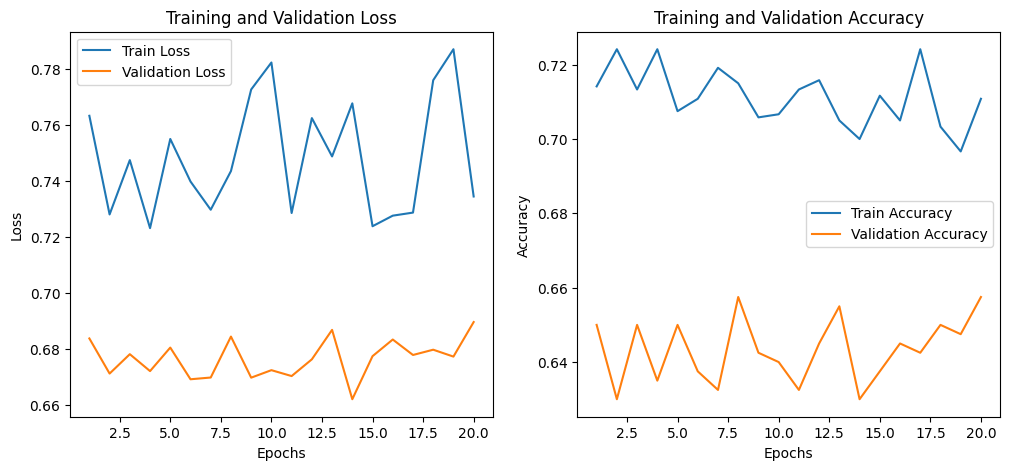

In [44]:
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, device, criterion, optimizer, lr_scheduler, num_epochs=num_epochs,
    checkpoint_path='/content/drive/MyDrive/models/model9.pth'
)

plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)
